# Dataset

In [7]:
model_type = 'convnet' # baseline, resnet, resnet_pretrained, convnet
restart_scheduler = 5
merge_test = True

In [2]:
import sys
sys.path.append('../../datasets/')
from prepare_sequences import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

In [3]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = patch_len / 2                   # = 150ms ~ 15ms
seq_len = 60

resize = None

mode = 'slide'
options = {
    'seq_len': seq_len,                            # = 500ms with ~ 5 calls
    'seq_skip': 15,
}

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         options, mode, resize)

100%|███████████████████████████████████████████| 18/18 [00:18<00:00,  1.05s/it]


In [4]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 19190
(11323, 60, 44, 257) (11323,)


In [5]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4979
(4979, 60, 44, 257) (4979,)


In [6]:
print("Total sequences:", len(X_val))
print(X_val.shape, Y_val.shape)

Total sequences: 2888
(2888, 60, 44, 257) (2888,)


# Model
Sequence -> Feature map -> pos. encoding -> Transformer (CLS)

In [8]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

sys.path.append('../addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchsummary import summary
from torchmetrics.functional import f1_score

In [9]:
use_sampler = False
use_reduceonplateu = False
use_cosinescheduler = True
use_sam = True

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [11]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        patch_dim,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        classifier_dropout=0.1,
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"
        
        if model_type == 'baseline':
            pass
        elif model_type == 'resnet':
            self.to_patch_embedding = ResNet(resnet_size, image_channels=1, num_classes=num_classes, include_last=False)
        elif model_type == 'resnet_pretrained':
            self.to_patch_embedding = ResNet(18, image_channels=1, num_classes=num_classes, include_last=False)
            self.to_patch_embedding.load_state_dict(torch.load('baseline.pth'), strict=False)
        elif model_type == 'convnet':
            self.to_patch_embedding = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=(5, 7), stride=(2, 3), padding=3),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

                nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=5, stride=2, padding=1),

                nn.Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 2), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
    
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len + 1, d_model))

        self.dropout = nn.Dropout(p=dropout)
        
        self.transformer_encoder = Transformer(
            dim=d_model,
            depth=num_layers,
            heads=nhead,
            dim_head=16,
            mlp_dim=dim_feedforward,
            dropout=dropout)
        
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
        
        self.d_model = d_model

    def forward(self, x):
        if model_type == 'baseline':
            pass
        elif model_type == 'resnet' or model_type == 'resnet_pretrained' or model_type == 'convnet':
            b, n, w, h = x.shape
            x = x.reshape((b * n, 1, w, h))
            x = self.to_patch_embedding(x)
            x = x.reshape((b, n, d_model))
        
        cls = einops.repeat(self.cls_token, '1 n d -> b n d', b=x.shape[0])
        x = torch.cat((cls, x), dim=1)
        x += self.pos_encoder
        
        x = self.dropout(x)
        x = self.transformer_encoder(x)
        
        x = x[:, 0]
        x = self.classifier(x)
        return x

In [12]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(3-rand_k):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx].squeeze()
            Y2[i] += Y1[idx].squeeze()
    return X2, Y2

def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / max(t.sum(), output[i].sum())
    return corr

In [13]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        if use_sam:
            optimizer.first_step()
            criterion(model(inputs), labels).backward()
            optimizer.second_step()
        else:
            optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [14]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [21]:
from torchsampler import ImbalancedDatasetSampler

max_len = seq_len
batch_size = 64
epochs = 25
lr = .0005
warmup_epochs = 5
if model_type == "convnet":
    d_model = 64
else:
    d_model = 512
    

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

if merge_test:
    X_train = np.concatenate((X_train, X_test), axis=0)
    Y_train = np.concatenate((Y_train, Y_test), axis=0)
    X_test = X_val
    Y_test = Y_val
    
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)
train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

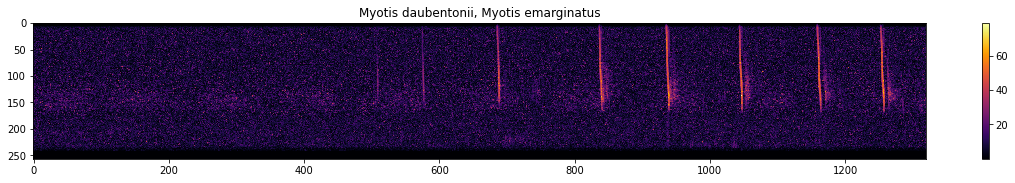

In [22]:
def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
plot_sequence(X1[k].detach().numpy(), Y1[k].detach().numpy())

In [23]:
model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [24]:
import wandb
from losses import AsymmetricLoss

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout,
    
    "use_sampler": use_sampler,
    "use_reduceonplateu": use_reduceonplateu,
    "use_cosinescheduler": use_cosinescheduler,
    "use_sam": use_sam,
    "mege_test": merge_test
}

wandb.init(project="BAT-2-mixed", entity="frankfundel", config=wandb_config)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2/16), weight=torch.tensor(100)) # contains sigmoid
#criterion = AsymmetricLoss(gamma_neg=0, gamma_pos=0, clip=0, disable_torch_grad_focal_loss=True)
#criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=2, clip=0, disable_torch_grad_focal_loss=True)
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0, disable_torch_grad_focal_loss=True)


if use_sam:
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [25]:
num_classes = len(list(classes))
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_2_' + model_type + '_mixed.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 299/299 [03:07<00:00,  1.59it/s]

Training loss: 118.2166 Acc: 0.3855



100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.15it/s]

Validation loss: 101.5240 Acc: 0.5525
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████| 299/299 [03:33<00:00,  1.40it/s]

Training loss: 90.4992 Acc: 0.5516



100%|███████████████████████████████████████████| 45/45 [00:21<00:00,  2.12it/s]

Validation loss: 83.8476 Acc: 0.6182
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████| 299/299 [03:42<00:00,  1.34it/s]

Training loss: 82.3271 Acc: 0.6005



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  4.08it/s]

Validation loss: 76.0706 Acc: 0.6768
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 299/299 [03:16<00:00,  1.52it/s]

Training loss: 77.0034 Acc: 0.6430



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.30it/s]

Validation loss: 72.0595 Acc: 0.7101
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|█████████████████████████████████████████| 299/299 [03:38<00:00,  1.37it/s]

Training loss: 74.4312 Acc: 0.6602



100%|███████████████████████████████████████████| 45/45 [00:17<00:00,  2.64it/s]

Validation loss: 70.3253 Acc: 0.7211
val_loss decreased, saving model
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████| 299/299 [03:20<00:00,  1.49it/s]

Training loss: 75.2806 Acc: 0.6566



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.59it/s]

Validation loss: 67.2293 Acc: 0.7152
val_loss decreased, saving model
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 299/299 [03:20<00:00,  1.49it/s]

Training loss: 70.1073 Acc: 0.6941



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.54it/s]

Validation loss: 67.2755 Acc: 0.7391
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 299/299 [03:16<00:00,  1.52it/s]

Training loss: 64.7461 Acc: 0.7260



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.29it/s]

Validation loss: 64.7866 Acc: 0.7407
val_loss decreased, saving model
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 299/299 [03:25<00:00,  1.46it/s]

Training loss: 60.9168 Acc: 0.7497



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.33it/s]

Validation loss: 55.6773 Acc: 0.7986
val_loss decreased, saving model
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 299/299 [03:26<00:00,  1.45it/s]

Training loss: 58.2808 Acc: 0.7629



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.71it/s]

Validation loss: 49.8019 Acc: 0.8165
val_loss decreased, saving model
==================== Starting at epoch 10 ====================



100%|█████████████████████████████████████████| 299/299 [03:16<00:00,  1.52it/s]

Training loss: 56.6980 Acc: 0.7718



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.76it/s]

Validation loss: 52.1117 Acc: 0.8065
==================== Starting at epoch 11 ====================



100%|█████████████████████████████████████████| 299/299 [03:19<00:00,  1.50it/s]

Training loss: 60.5025 Acc: 0.7494



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.37it/s]

Validation loss: 61.0839 Acc: 0.7642
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████| 299/299 [03:19<00:00,  1.50it/s]

Training loss: 58.4363 Acc: 0.7627



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.44it/s]

Validation loss: 68.2034 Acc: 0.7437
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 299/299 [03:21<00:00,  1.48it/s]

Training loss: 56.1797 Acc: 0.7767



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.78it/s]

Validation loss: 49.6788 Acc: 0.8251
val_loss decreased, saving model
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████| 299/299 [03:19<00:00,  1.50it/s]

Training loss: 53.7152 Acc: 0.7884



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.31it/s]

Validation loss: 45.1316 Acc: 0.8384
val_loss decreased, saving model
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████| 299/299 [03:22<00:00,  1.48it/s]

Training loss: 50.9828 Acc: 0.8024



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.67it/s]

Validation loss: 43.6054 Acc: 0.8381
val_loss decreased, saving model
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 299/299 [03:18<00:00,  1.51it/s]

Training loss: 49.7565 Acc: 0.8089



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.72it/s]

Validation loss: 44.4348 Acc: 0.8436
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 299/299 [03:19<00:00,  1.50it/s]

Training loss: 54.8081 Acc: 0.7840



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.62it/s]

Validation loss: 53.3114 Acc: 0.8031
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 299/299 [03:23<00:00,  1.47it/s]

Training loss: 52.3714 Acc: 0.7964



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.42it/s]

Validation loss: 49.1860 Acc: 0.8106
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████| 299/299 [03:25<00:00,  1.45it/s]

Training loss: 51.3200 Acc: 0.8027



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.68it/s]

Validation loss: 43.7904 Acc: 0.8440
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 299/299 [03:19<00:00,  1.50it/s]

Training loss: 48.8037 Acc: 0.8105



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.05it/s]

Validation loss: 40.2361 Acc: 0.8628
val_loss decreased, saving model
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 299/299 [03:21<00:00,  1.48it/s]

Training loss: 47.6403 Acc: 0.8208



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.79it/s]

Validation loss: 39.0583 Acc: 0.8569
val_loss decreased, saving model
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 299/299 [03:13<00:00,  1.54it/s]

Training loss: 46.3164 Acc: 0.8265



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.78it/s]

Validation loss: 40.4760 Acc: 0.8536
==================== Starting at epoch 23 ====================



100%|█████████████████████████████████████████| 299/299 [03:16<00:00,  1.52it/s]

Training loss: 49.9471 Acc: 0.8102



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.77it/s]

Validation loss: 44.8578 Acc: 0.8395
==================== Starting at epoch 24 ====================



100%|█████████████████████████████████████████| 299/299 [03:15<00:00,  1.53it/s]

Training loss: 49.7462 Acc: 0.8113



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.65it/s]

Validation loss: 41.4445 Acc: 0.8396


In [26]:
model.load_state_dict(torch.load('bat_2_' + model_type + '_mixed.pth'))
#compiled_model = torch.jit.script(model)
#torch.jit.save(compiled_model, 'bat_1.pt')

<All keys matched successfully>

In [27]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm.tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


In [28]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

test_acc = mixed_corrects / (repeats * len(test_data))
f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", test_acc)
print("Mixed f1 micro:", f1_micro)
print("Mixed f1 macro:", f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.8594, device='cuda:0')
Mixed f1 micro: 0.8294127111826226
Mixed f1 macro: 0.7661423441675892
69970 params


In [29]:
wandb.log({
    "test_acc": test_acc,
    "f1_micro": f1_micro,
    "f1_macro": f1_macro,
    "num_params": pytorch_total_params,
})

In [30]:
wandb.finish()

f1_macro,▁
f1_micro,▁
num_params,▁
test_acc,▁
train_acc,▁▄▄▅▅▅▆▆▇▇▇▇▇▇▇██▇███████
train_loss,█▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
val_acc,▁▂▄▅▅▅▅▅▇▇▇▆▅▇▇▇█▇▇████▇▇
val_loss,█▆▅▅▅▄▄▄▃▂▂▃▄▂▂▂▂▃▂▂▁▁▁▂▁
f1_macro,0.76614
f1_micro,0.82941
num_params,69970


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|███████████████████████████████████████████| 45/45 [00:10<00:00,  4.23it/s]


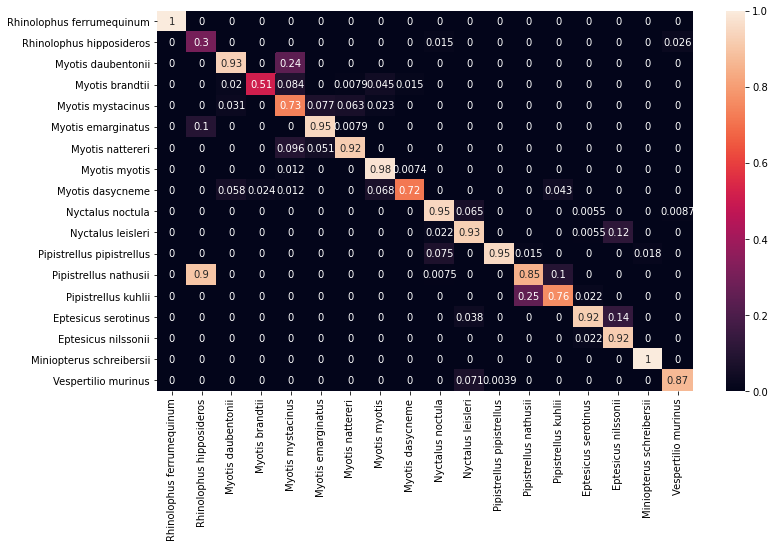

In [32]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_2_' + model_type + '_mixed_cf.png')

In [33]:
import sklearn
corrects = np.equal(Y_pred, Y_true).sum()
test_acc = corrects/len(Y_pred)
f1 = sklearn.metrics.f1_score(Y_true, Y_pred, average=None).mean()
print("Test accuracy:", test_acc)
print("F1-score:", f1)

Test accuracy: 0.8892361111111111
F1-score: 0.8422677369002991
